In [39]:
#!pip install mlxtend torchmetrics

In [1]:
# Created by Dr. Moh Khalaf to help my team to review basics concepts
# torch
import torch
from torch import nn

# computer vision
import torchvision
from torchvision import datasets , transforms
from torchvision.transforms import ToTensor

#  DataLoader
from torch.utils.data import DataLoader
#TensorDataset is a class from the torch.utils.data module that is used to store data in the form of tensors.
#It is particularly useful when you want to pair input data (features) with corresponding labels, creating a dataset
#that can be easily used with PyTorch DataLoader

from torch.utils.data import TensorDataset   ## help to convert (images, label) to TensorDataset

import torch.nn.functional as F
#F is a common alias for torch.nn.functional, which is a module containing various functions
#(like activation functions, convolution operations, pooling, etc.) that don’t require creating layer objects.
#Instead, they are called directly as functions, which is often more convenient in certain scenarios,
#like when you're defining custom layers.

# Visualization
import matplotlib.pylab as plt
# import the timer
from timeit import default_timer as timer
# from tqdm import tqdm  Bar visulization
from tqdm.auto import tqdm

import random    # to use the random.samples()

# for confusion Matrix
import mlxtend  , torchmetrics 
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Checks if a CUDA-capable GPU is available on the system
device = "cuda" if torch.cuda.is_available() else "cpu"

In [41]:
#!pip install mlxtend torchmetrics

### 1- Prepare the Data (Getting the Dataset CIFAR10)

In [132]:
train_data = datasets.CIFAR10(
    root="data", # the folder name to download dataset on it
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(), # transform data to tensor
    target_transform=None # no need to transform the labels  (target means labels)
)

test_data = datasets.CIFAR10(
    root='data',train=False,download=True,transform=torchvision.transforms.ToTensor(),target_transform=None)


Files already downloaded and verified
Files already downloaded and verified


In [133]:
class_names = train_data.classes
class_index = train_data.class_to_idx
class_index

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [4]:
train_data , test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### Check the data

In [5]:
def plot_fn(data, cmap1 = None, title1 = None, text : str =" "):
    """
    data is the dataset in the form of ( Color , H , W )
    cmap1 = %colors ,
    title1 -->label
    text --> data type  -->> training , testing , eval .......
    """
    torch.manual_seed(42)
    fig = plt.figure(figsize= (16,5))   ### ( W , H )
    rows , cols = 2,10
    print(f'"\n" + " " * 20 + "----------- Plotting  {rows} * {cols} samples with label  {text}-----------" + "\n"')
    classNames = data.classes
    for i in  range(rows*cols) :
        imageSelected, labelSelected = data[i]
        fig.add_subplot(rows, cols, i+1)
        imageResahape = imageSelected.permute(1,2,0).squeeze()

        cmap = cmap1[i] if cmap1 is not None else "gray"
        title = title1[i] if title1 is not None else classNames[labelSelected]
        plt.imshow(imageResahape , cmap = cmap)
        plt.title(title)
        plt.axis(False)


"
" + " " * 20 + "----------- Plotting  2 * 10 samples with label   -----------" + "
"


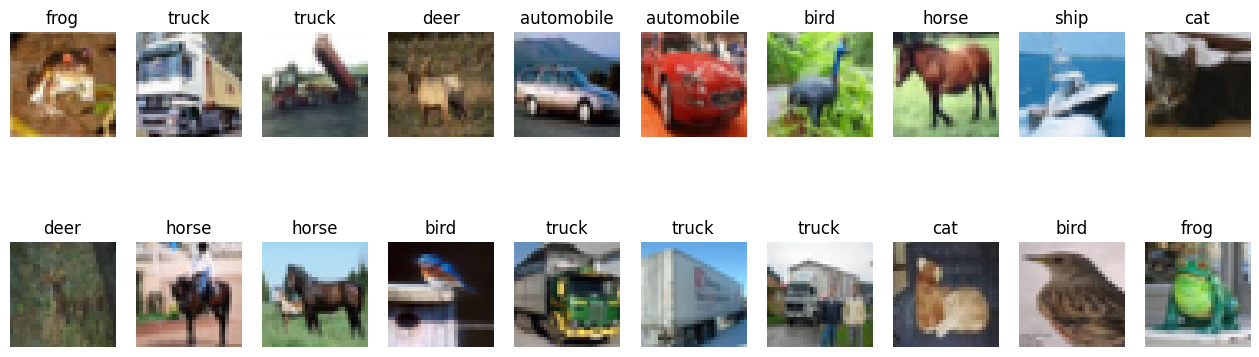

In [6]:
plot_fn(train_data)

### Batching the data
By using a DataLoader, you can simplify your training loop, improve the performance of your model, and It is essential for efficient and effective training of neural networks.
* Handles large datasets by loading data in smaller batches, reducing memory consumption.
* Optimizes data loading and preprocessing for faster training.

In [6]:

BATCH_SIZE = 32
train_dataLoader = DataLoader( dataset= train_data, batch_size=BATCH_SIZE , shuffle=True)
test_dataLoader  = DataLoader( dataset= test_data , batch_size=BATCH_SIZE , shuffle= False)

len(train_data)  , len (train_dataLoader)

(50000, 1563)

In [8]:
### what is the data shape coming out fromthe data loader
train_dataLoader_features_per_batch , train_dataLoader_label_per_batch =  next(iter(train_dataLoader))

train_dataLoader_features_per_batch.shape  # [ batch size , color , H , W ]


torch.Size([32, 3, 32, 32])

 ### Building ResNet 56 CNN model
 ResNet-56
* 1. Residual Layers: 56 - 2 = 54
* 2. Number of stages: 54 / 3 = 18
* 3. Blocks per Stage: 18 / 3 = 6
     
So, ResNet-56 has 3 stages with 9 blocks per stage.
## General ResNet Structure for CIFAR
1. Initial Layer: 1 convolutional layer
2. Residual Stages: Each stage has a series of residual blocks. Each block consists of 2
convolutional layers.
3. Fully Connected Layer: 1 fully connected layer at the end for classification.

<img src="src/buildingblocks.png"/>

In [7]:
#
class BottleNeckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):

        super().__init__()
        # First layer: 1x1 convolution to reduce channels
        self.firstlayer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels//4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU()
        )
        # Second layer: 3x3 Convolution
        self.secondlayer = nn.Sequential(
            nn.Conv2d(in_channels=out_channels//4, out_channels=out_channels//4, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU()
        )
        # Third layer: 1x1 convolution to expand channels back to out_channels
        self.thirdlayer = nn.Sequential(
            nn.Conv2d(in_channels=out_channels//4, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
        # Skip connection for matching dimension
        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.skip_connection(x)
        x = self.firstlayer(x)
        x = self.secondlayer(x)
        x = self.thirdlayer(x)
        # Adding the residual connection with ReLU activation
        x = F.relu(x + residual)
        return x


class ResNet56(nn.Module):

    def __init__(self, input_features=3, hidden_units=64, output_classes=10): # output_features = number of classes
        super().__init__()
        self.current_channels = hidden_units  # Renamed for clarity
        # Initial Convolution layer
        self.initLayer = nn.Sequential(
            nn.Conv2d(in_channels=input_features, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU()
        )
        # Residual Layers (18 stages, 6 blocks )
        self.residual_blocks = nn.Sequential(
            self._generateLayers(64, numOfBlocks=6, stride=1),  # 64
            self._generateLayers(128, numOfBlocks=6, stride=2),  # 128
            self._generateLayers(256, numOfBlocks=6, stride=2)   # 256
        )
        # Final fully connected layer and Global Average Pooling
        self.fullyConnectedLayer = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, output_classes)
        )

    def _generateLayers(self, out_channels, numOfBlocks, stride):
        layers = []
        for i in range(numOfBlocks):
            if i == 0:
                layers.append(BottleNeckResidualBlock(self.current_channels, out_channels, stride=stride))
            else:
                layers.append(BottleNeckResidualBlock(out_channels, out_channels, stride=1))
            self.current_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initLayer(x)
        x = self.residual_blocks(x)
        x = self.fullyConnectedLayer(x)
        return x


In [9]:
model1 = ResNet56()

In [51]:
print(model1.parameters(train_dataLoader_features_per_batch))

<generator object Module.parameters at 0x7d519423ef80>


### Create Accuracy Function

In [15]:
def accuracy_fn(y_true, y_pred):
    """accuracy function needs to enter the True data and the predected data """
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

### Create loss and optimizer

In [10]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(params=model1.parameters(),
                            #  lr=0.02)
# Initialize the SGD optimizer
optimizer =torch.optim.SGD(
    params=model1.parameters(),  # The model parameters to update during training.
    lr=0.02,                    # Learning rate; controls how much to adjust parameters per step.
    momentum=0.9,               # Momentum; helps accelerate gradient descent and avoid local minima.
    weight_decay=1e-4           # Weight decay (L2 regularization); helps prevent overfitting.
)


### Create the train function

In [54]:
def training_fn(model:nn.Module, data_loader : torch.utils.data.DataLoader,
                optimizer : torch.optim.SGD,
                loss_fn : torch.nn.Module,
                accuracy_fn , device : torch.device = device):

    #initial values
    trainLoss, trainAccuracy = 0 , 0
    model.to(device)
    model.train() # set the mode to training mode

    for batch , ( X , y ) in enumerate( data_loader ) :
        X , y  = X.to(device) , y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate the loss
        loss = loss_fn( y_pred , y)
        trainLoss +=loss
        trainAccuracy += accuracy_fn(y_true = y , y_pred = y_pred.argmax(dim = 1))
        # 3. optimizer zero grad
        optimizer.zero_grad()
        # 4. loss backward
        loss.backward()
        # 5 . optimizer step
        optimizer.step()
    trainLoss /= len(data_loader)
    trainAccuracy /= len(data_loader)
    print(f"Model training loss : {trainLoss : 0.5f} | Model Accuracy : {trainAccuracy:0.2f}")


### Create the test function

In [13]:
def test_fn( model:torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             device : torch.device=device):
  # initial values and setup
    testLoss , testAccuracy = 0 , 0
    model.to(device)
    model.eval() # put model in the evaluation mode
 # Turn on the infernce context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # send data to device
            X, y = X.to(device), y.to(device)
            # Forward pass
            test_pred = model(X)
            #Calculate the loss and accuracy
            testLoss += loss_fn(test_pred, y)
            testAccuracy+=accuracy_fn(y_true = y, y_pred=test_pred.argmax(dim=1))
    testLoss = testLoss /len(data_loader)
    testAccuracy/=len(data_loader)
    print(f" Model testing Loss : {testLoss:0.5f} | Model testing Accuracy : {testAccuracy:0.2f} ")



### Training  the model1

In [56]:
torch.manual_seed(42)
startTime = timer()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# endTime = timer()
epochs = 40
# Initialize the progress bar outside the epoch loop
pbar = tqdm(total=len(train_dataLoader) * epochs, desc="Training")

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f'Learning rate at epoch {epoch+1}: {scheduler.get_last_lr()[0]:.5f}')

    # Call the training function
    training_fn(data_loader=train_dataLoader, model=model1, optimizer=optimizer, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
    # Step the scheduler at the end of each epoch
    # Optionally, print the current learning rate after each epoch to track changes
    scheduler.step()
    # Update the progress bar after each batch in the data loader (not per epoch)
    pbar.update(len(train_dataLoader))  # Each epoch corresponds to `len(train_dataLoader)` updates


# Close the progress bar once training is done
pbar.close()

endTime = timer()

print(f"total training time is  :  {endTime-startTime}")


Training:   0%|          | 0/62520 [00:00<?, ?it/s]

Epoch 1/40
Learning rate at epoch 1: 0.02000
Model training loss :  1.70176 | Model Accuracy : 36.07
Epoch 2/40
Learning rate at epoch 2: 0.02000
Model training loss :  1.15973 | Model Accuracy : 58.06
Epoch 3/40
Learning rate at epoch 3: 0.02000
Model training loss :  0.87863 | Model Accuracy : 69.02
Epoch 4/40
Learning rate at epoch 4: 0.02000
Model training loss :  0.71000 | Model Accuracy : 75.08
Epoch 5/40
Learning rate at epoch 5: 0.02000
Model training loss :  0.59977 | Model Accuracy : 79.04
Epoch 6/40
Learning rate at epoch 6: 0.02000
Model training loss :  0.52894 | Model Accuracy : 81.70
Epoch 7/40
Learning rate at epoch 7: 0.02000
Model training loss :  0.48222 | Model Accuracy : 83.13
Epoch 8/40
Learning rate at epoch 8: 0.02000
Model training loss :  0.42987 | Model Accuracy : 84.83
Epoch 9/40
Learning rate at epoch 9: 0.02000
Model training loss :  0.39235 | Model Accuracy : 86.23
Epoch 10/40
Learning rate at epoch 10: 0.02000
Model training loss :  0.35995 | Model Accur

In [58]:
# save the model
#torch.save(obj=model1.state_dict(), f = "model1gpu.pt")


In [60]:
#torch.save(model1, "entire_model1.pt")

### Testing the model

In [11]:
model_test = ResNet56()

model_test.load_state_dict(torch.load('model1gpu-3.pt', map_location=torch.device('cpu')))



<All keys matched successfully>

In [16]:

torch.manual_seed(42)

startTime = timer()

epochs = 4
pbar = tqdm(total=epochs, desc="Model Testing")
# for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    test_fn(data_loader=test_dataLoader,
        model=model_test,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn    )
    pbar.update(1)  # Update the progress bar by 1
    
pbar.close()  # Close the progress bar

endTime = timer()

print(f"total training time :{endTime-startTime}")

Model Testing:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
---------
 Model testing Loss : 0.69194 | Model testing Accuracy : 85.90 
Epoch: 1
---------
 Model testing Loss : 0.69194 | Model testing Accuracy : 85.90 
Epoch: 2
---------
 Model testing Loss : 0.69194 | Model testing Accuracy : 85.90 
Epoch: 3
---------
 Model testing Loss : 0.69194 | Model testing Accuracy : 85.90 
total training time :435.7070008999999


### Create the Prediction function

In [17]:
def prediction_fn(model: torch.nn.Module, data: torch.Tensor, device: torch.device = device):
    '''Returns the predicted class for each sample in the data'''
    model.eval()  # Set model to evaluation mode
    predictionProbabilities = []
    
    with torch.inference_mode():  # Disable gradient calculations for inference
        data = data.to(device)  # Move data to device (GPU/CPU)
        
        # Forward pass for the whole batch at once
        pred_out = model(data)  # Shape: [batch_size, num_classes]
        
        # Get the probability using softmax
        pred_Probability = torch.softmax(pred_out, dim=1)  # Softmax over the class dimension
        
        # Store the probabilities
        predictionProbabilities = pred_Probability.cpu()  # Move probabilities to CPU

    # Get predicted class labels using argmax
    predectedClasses = predictionProbabilities.argmax(dim=1)  # Get the index of the maximum probability for each sample
    
    return predectedClasses


In [25]:
### Run the Model Prediction 
# a) Create random samples from the test data


import torch

# Assuming you're getting a single batch from your DataLoader
sample, label = next(iter(test_dataLoader))  # This gets the first batch
testImageSamples = sample
testImageLabels = label

# Check if the batch has the correct shape [batch_size, channels, height, width]
if sample.shape[0] == 32:  # Assuming the batch size is 32
    testImageSamples_tensor = sample  # No need to stack since there's only one batch
    testImageLabels_tensor = label     # Use the labels directly
   
    print(f"The shape of the batched test samples: {testImageSamples_tensor.shape}")  # Should be [32, 3, 32, 32]
    print(f"Shape of the labels: {testImageLabels_tensor.shape}")  # Should be [32]

# If the batch shape is incorrect, you can handle it here
else:
    print(f"Batch shape mismatch! Expected [32, 3, 32, 32] but got {sample.shape}")


The shape of the batched test samples: torch.Size([32, 3, 32, 32])
Shape of the labels: torch.Size([32])


### there is one batch with uncorect size which can affect the testing phase

In [66]:
prediction_results = prediction_fn(model=model_test, data=testImageSamples_tensor)  # Labels predicted
# Visualize the predictions
real_result = testImageLabels_tensor
real_images = testImageSamples_tensor

In [144]:
testImageSamples_tensor.shape


torch.Size([32, 3, 32, 32])

In [67]:
print(f"predicted : {prediction_results}") 
print(f"real values : {real_result}") 
print(f"image shape : {real_images.shape}")

predicted : tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 6, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 3, 4, 0, 9, 6, 6, 5])
real values : tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5])
image shape : torch.Size([32, 3, 32, 32])


In [118]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_results_fn(prediction_result, real_result, real_images, classNames, text="Predicted data"):
    """
    predicted : tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 6, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 3, 4, 0, 9, 6, 6, 5])
real values : tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5])
        
    text --> data type  -->> training , testing , eval .......
    """
    rows, cols = 6, 5
    print(f"\n{' ' * 20}----------- Plotting {rows} * {cols} samples with label {text} -----------\n")
    fig = plt.figure(figsize= (20,10))   ### ( W , H )
    for i in range(rows * cols):
        # Permute the image dimensions to (height, width, channels)
        imageReshape = real_images[i].permute(1, 2, 0).cpu().numpy()
            # Set colormap and title color based on prediction accuracy
        correct_prediction = prediction_result[i] == real_result[i]
        border_color = "green" if correct_prediction else "red"
        title_color = "blue" if correct_prediction else "red"
        # cmap = "Reds"  # or another valid colormap if desired
        title = f"pred: {classNames[prediction_result[i]]} | real: {classNames[real_result[i]]}"
        
        # Plot image
        fig = plt.subplot(rows, cols, i + 1)
        plt.imshow(imageReshape)
        plt.title(title, fontsize=14, color=title_color)
        plt.axis("off")
        
        # Add square border around the image
        rect = patches.Rectangle((0, 0), 32, 32, linewidth=4, edgecolor=border_color, facecolor='none')
        ax.add_patch(rect)

    plt.show()



                    ----------- Plotting 6 * 5 samples with label Predicted data -----------



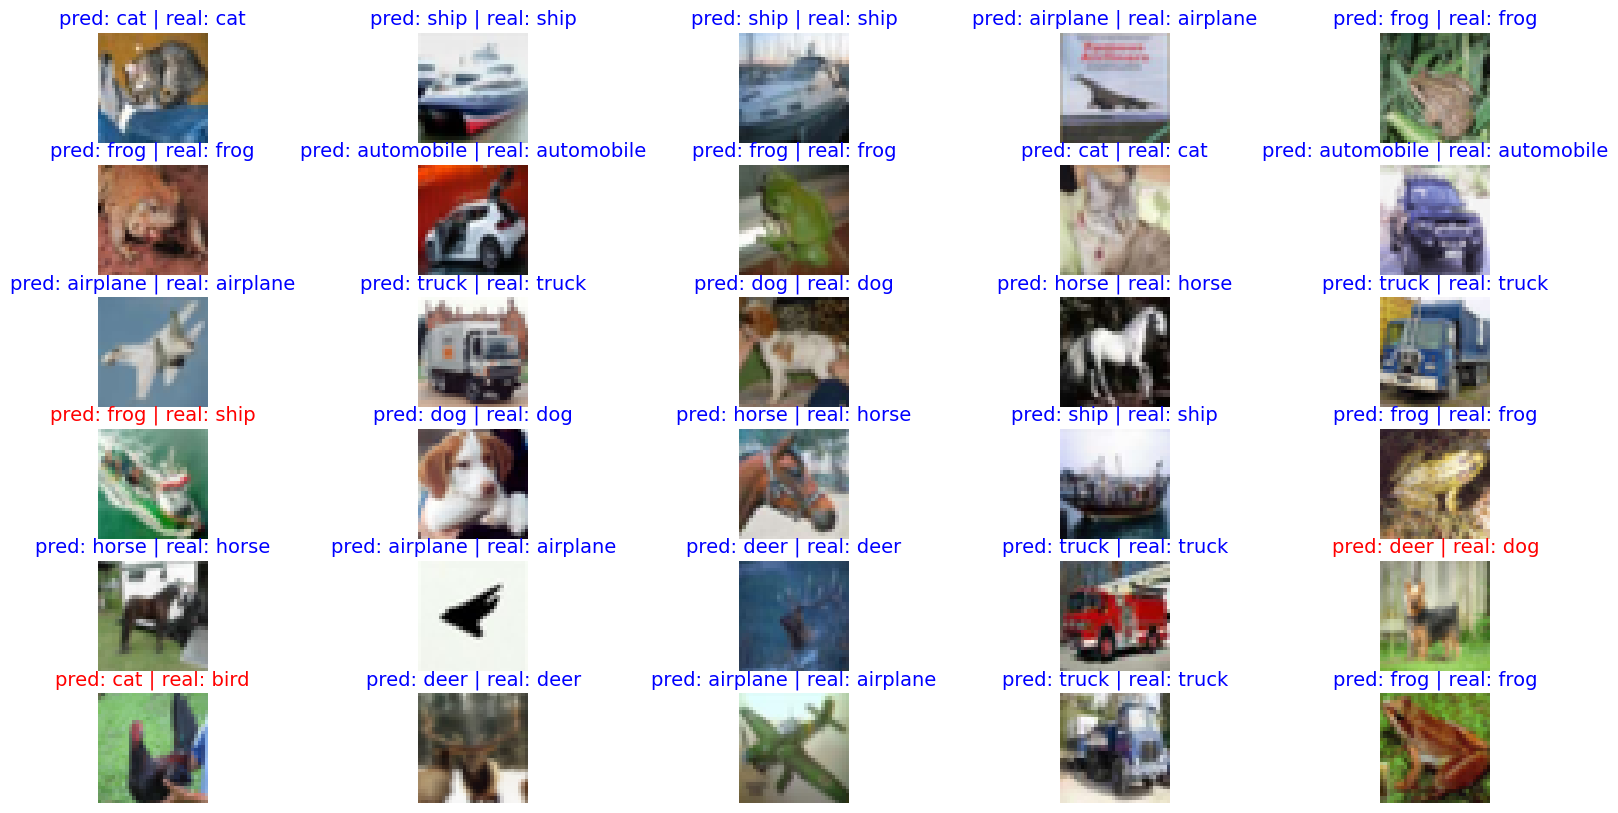

In [119]:
plot_results_fn(prediction_results, real_result, real_images, classNames , text="Predicted data")


## modify the test function to handel the batch mismatch
### Skip the batch if it doesn't have the correct shape (batch size is not 32)


In [120]:
def new_test_fn(model: torch.nn.Module,
            data_loader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            accuracy_fn,
            device: torch.device = device):
    # Initialize values and setup
    testLoss, testAccuracy = 0, 0
    model.to(device)
    model.eval()  # Put model in evaluation mode
    
    # Turn on the inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Skip the batch if it doesn't have the correct shape (batch size is not 32)
            if X.shape[0] != 32:
                continue  # Skip this batch and move to the next one

            # Send data to device
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            test_pred = model(X)
            
            # Calculate the loss and accuracy
            testLoss += loss_fn(test_pred, y)
            testAccuracy += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Compute average loss and accuracy
    testLoss = testLoss / len(data_loader)
    testAccuracy /= len(data_loader)
    
    print(f"Model testing Loss: {testLoss:0.5f} | Model testing Accuracy: {testAccuracy:0.2f}")


# the Confusion matrix 

predictedTestData_tensor = torch.cat(predictedTestData) to converte the list of tensors ( 32 element / tensor) to one tensor

In [150]:
TestImages, TestLabels , predictedTestData , realTestLabels = [] , [] , [] , []

pbar = tqdm(total=len(test_dataLoader), desc="Prediction")

for X, y in test_dataLoader :
    X , y = X.to(device) , y.to(device)
    TestImages =  X
    TestLabels =  y 
    predictedTestData.append( prediction_fn(model=model_test, data=TestImages))
    realTestLabels.append(TestLabels)
    pbar.update(1)  # Update the progress bar by 1
pbar.close()  


Prediction:   0%|          | 0/313 [00:00<?, ?it/s]

In [154]:
predictedTestData_tensor = torch.cat(predictedTestData) # to converte the list of tensors ( 32 element / tensor) to one tensor
realTestLabels_tensor = torch.cat(realTestLabels) # to converte the list of tensors ( 32 element / tensor) to one tensor

In [155]:
print("Shape of predictedTestData_tensor:", predictedTestData_tensor.shape)

Shape of predictedTestData_tensor: torch.Size([10000])


In [156]:
print("Shape of real test Labels tensor:" , realTestLabels_tensor.shape)


Shape of real test Labels tensor: torch.Size([10000])


In [138]:
# # Slice predictedTestData_tensor to match the target length
# predictedTestData_tensor = predictedTestData_tensor[:10000]

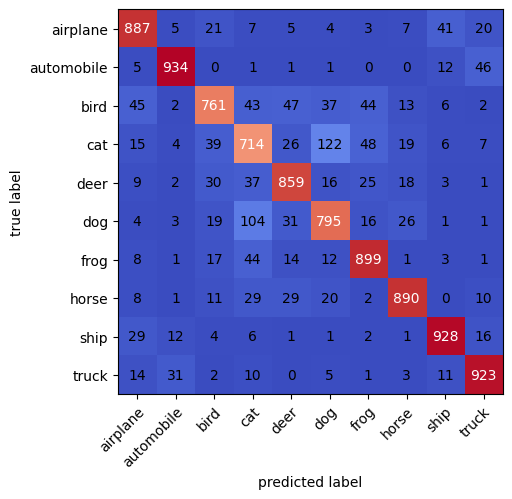

In [157]:
# !pip install mlxtend 
import mlxtend  , torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#  setup confusion instance and compare prediction to the original 
confMat = ConfusionMatrix(num_classes = len(class_names) , task = 'multiclass')

confMatTensor = confMat( preds = predictedTestData_tensor , 
                        target = realTestLabels_tensor  # test_data.targets 
                       )
# plot the confusion matrix
fig , ax = plot_confusion_matrix(
           conf_mat=confMatTensor.numpy(), 
           class_names=classNames, cmap='coolwarm',
           figsize=(5 , 5)
)


In [158]:
model_test

ResNet56(
  (initLayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (residual_blocks): Sequential(
    (0): Sequential(
      (0): BottleNeckResidualBlock(
        (firstlayer): Sequential(
          (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (secondlayer): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (thirdlayer): Sequential(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (skip_con

In [160]:
!pip install torchinfo

In [161]:
from torchinfo  import summary

In [162]:
summary(model_test, input_size=[1,3,64,64])

Layer (type:depth-idx)                        Output Shape              Param #
ResNet56                                      [1, 10]                   --
├─Sequential: 1-1                             [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                            [1, 64, 64, 64]           1,792
│    └─BatchNorm2d: 2-2                       [1, 64, 64, 64]           128
│    └─ReLU: 2-3                              [1, 64, 64, 64]           --
├─Sequential: 1-2                             [1, 256, 16, 16]          --
│    └─Sequential: 2-4                        [1, 64, 64, 64]           --
│    │    └─BottleNeckResidualBlock: 3-1      [1, 64, 64, 64]           4,640
│    │    └─BottleNeckResidualBlock: 3-2      [1, 64, 64, 64]           4,640
│    │    └─BottleNeckResidualBlock: 3-3      [1, 64, 64, 64]           4,640
│    │    └─BottleNeckResidualBlock: 3-4      [1, 64, 64, 64]           4,640
│    │    └─BottleNeckResidualBlock: 3-5      [1, 64, 64, 64]           4,640
│